# Task:
## Semantically segment objects from image **AUTOMATICALLY** with the help of **META AI SAM**, without PROMPTS/TRAINING

---

### Segment all the pepperoni pieces from the pizza topping

![](https://i2.wp.com/lifemadesimplebakes.com/wp-content/uploads/2014/09/Classic-Pepperoni-Pizza-1.jpg)

---

## Approach:

![](https://raw.githubusercontent.com/yogendra-yatnalkar/SAM-Automatic-Semantic-Segmentation/main/support-assets/SAM-Automatic-Semantic-Segmentation.png)

**1. Automatic Mask Generation (AMG)**

Utilizing the Segment Anything Model (SAM) from the MetaAI SAM repository, perform instance segmentation on the entire image. This process will identify and isolate individual objects within the image.

**2. Patch-Embedding Extraction & Single Representation per Instance-Segment**

- For each generated instance-segment, extract the corresponding patch embedding. A patch embedding encapsulates a segment's visual features into a concise vector representation.

- To ensure effective association of each cluster with its corresponding segmentation mask, each instance segmentation mask should have a unique single embedding or single representation. **This mapping allows for the accurate assignment of semantic segmentation classes to individual objects.**

- To achieve this, we can extract all the patch embeddings from the encoder features of SAM and average them per segment.

**3. Clustering for Semantic Segmentation**

Treating each segment as a distinct data point, apply clustering algorithms to group similar segments together. Each resulting cluster represents a semantic segmentation class, encompassing objects with shared visual characteristics.

---
---

### Detailed Explanation

#### Patch Embedding and SAM Encoder

- Extract all patch embeddings from the SAM Encoder.

- The SAM model takes an input of **1024x1024** pixels.

- The default patch size is **16x16** pixels.

- Therefore, the input structure is **64x64x16x16**, where there are 64x64 patches, each with a size of 16x16 pixels.

- The SAM Encoder output is **256x64x64**.

- After shuffling the channels, the output becomes **64x64x256**.

- Observe the input-output transformation:
  
  ```
  64x64x16x16 --> 64x64x256
  ```

- This means that each 16x16 patch is represented by a 256-dimensional embedding vector.

#### Segment Embedding

- For each segment, find the corresponding patches and average their embedding vectors.
- For example, if there are 30 segments identified using Meta SAM Automatic Mask Generator (AMG), iterate through each segment and:
  1. Identify the corresponding patches and obtain their embeddings. For instance, if segment1 corresponds to **3 patches**, its patch embedding will be **3x256**. Similarly, if segment2 corresponds to **10 patches**, its patch embedding will be **10x256**.
  2. Average all the patch embeddings corresponding to that segment to obtain a single embedding vector. As a result, segment1's embedding vector will be **1x256**, segment2's embedding vector will be **1x256**, and so on.
- This process results in a **1x256 embedding vector** for each segment. For 30 segments, the representation will be **30x256**.

#### Semantic Class Clustering

- Cluster the segment embedding vectors using a clustering algorithm, such as **DBScan**. This algorithm is suitable since the number of segments is unknown.
- Each cluster formed represents a distinct semantic class.**


 ## Setting up of SAM model for Automatic Mask Generation

In [1]:
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
!wget https://i2.wp.com/lifemadesimplebakes.com/wp-content/uploads/2014/09/Classic-Pepperoni-Pizza-1.jpg

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-sy7dsvhp
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-sy7dsvhp
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=9b506411484f371ae4a312dba4f4a111e7063e8fcdf2b80d6068dd6502bc4ee8
  Stored in directory: /tmp/pip-ephem-wheel-cache-9_vybuf8/wheels/29/82/ff/04e2be9805a1cb48bec0b85b5a6da6b63f647645750a0e42d4
Successfully built segment_anything
--2025-09-11 08:22:14--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.37.90, 13.35.37.111, 13.35.37.84, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.37.90

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torchvision
from sklearn.cluster import DBSCAN
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

PyTorch version: 2.8.0+cu126
Torchvision version: 0.23.0+cu126
CUDA is available: True


In [3]:
# SAM initial model loading
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
sam_checkpoint = "/content/sam_vit_h_4b8939.pth"
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [4]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.9]])
        img[m] = color_mask
    ax.imshow(img)

### Sample image

IMG shape:  (1024, 1024, 3)


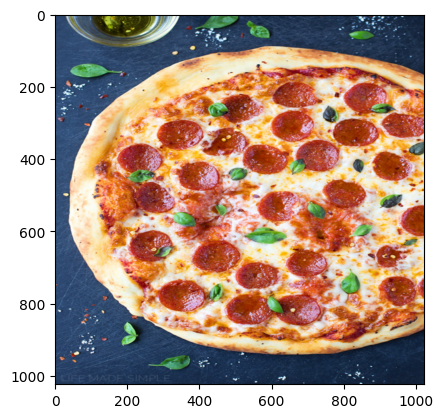

In [5]:
img_path = "/content/Classic-Pepperoni-Pizza-1.jpg"
img = cv2.imread(img_path)

# resizing the image to 1024x1024
img = cv2.resize(img, (1024, 1024))
print("IMG shape: ", img.shape)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## Sample image instance segmentation with Automatic-Mask-Generation

In [6]:
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=51,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

### Get the encoder embeddings

In [7]:
mask_generator.predictor.set_image(img_rgb)
enc_emb = mask_generator.predictor.features
enc_emb = enc_emb.to("cpu").numpy()
enc_emb = enc_emb[0].transpose((1,2,0))

print(enc_emb.shape)

(64, 64, 256)


### Generate mask using automatic-mask-generator

In [8]:
masks2 = mask_generator.generate(img_rgb)
masks2 = sorted(masks2, key=(lambda x: x['area']), reverse=True)
print("Number of masks: ", len(masks2))
print("Shape of individual mask: ",masks2[0]['segmentation'].shape)

Number of masks:  264
Shape of individual mask:  (1024, 1024)


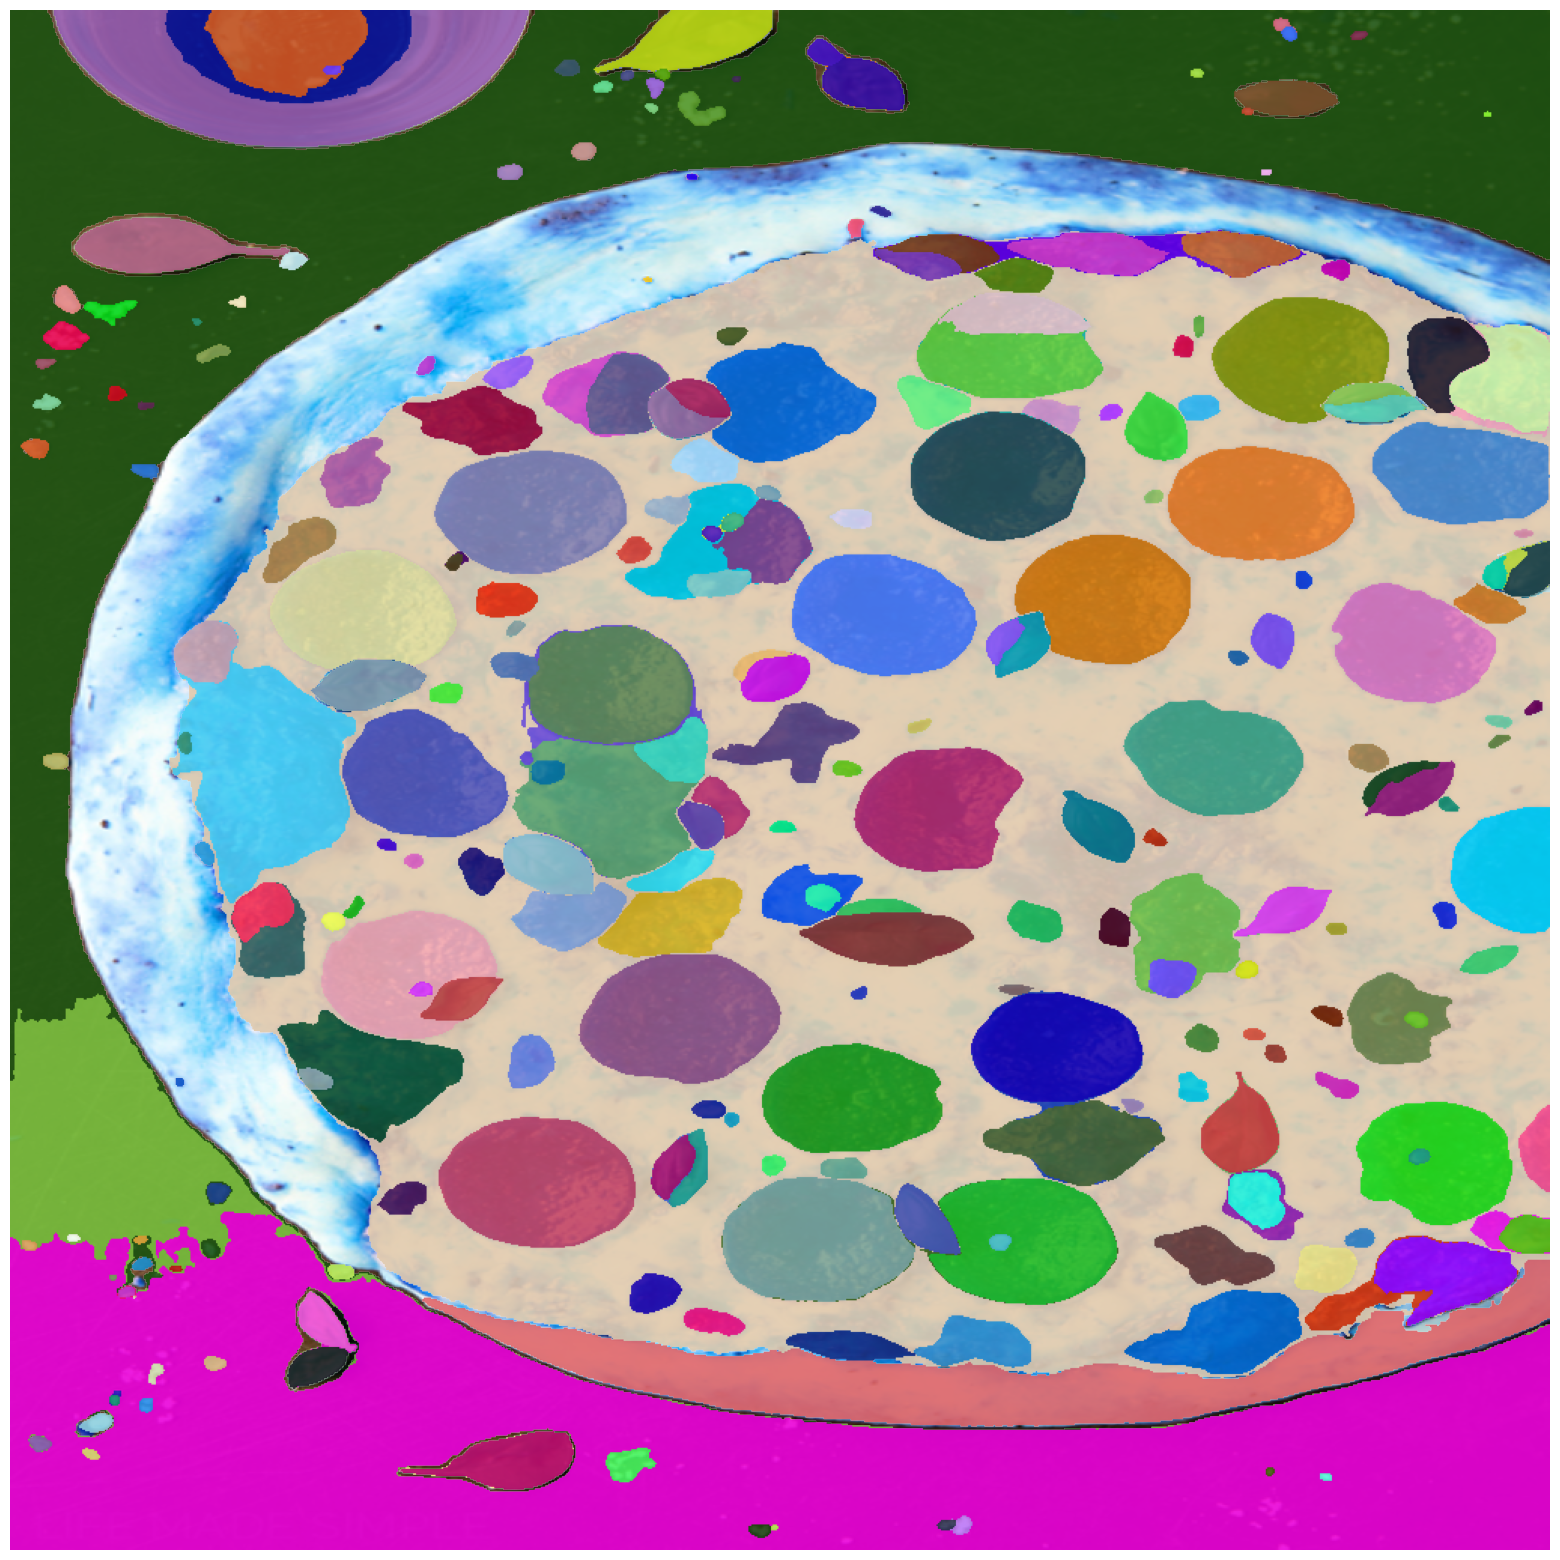

In [9]:
plt.figure(figsize=(20,20))
plt.imshow(img)
show_anns(masks2)
plt.axis('off')
plt.show()

## Get Mask Embedding for each segment:

#### Mask Embedding = Average of patch embeddings corresponding to individual segment

---

### Notes:

- As we can see, there are 264 masks created using Automatic-Mask-Generator
- The output-shape of encoder is: 256x64x64 --> which means its a 64x64 image with 256 channels
- **For each mask, get all the corresponding patch-embedding**
- **The average of all patch-embeddings for a given mask will be termed as "Mask Embedding"**

In [10]:
def get_mask_embedding_using_patch_embeddings(mask, enc_emb, return_all = False):
    # Converting mask of shape 1024x1024 to shape: 64x64x16x16
    # This assumes that patch size is 16x16 becuase what we mainly need is: 64x64 at the start
    # We are free to change the patch-size accordingly
    split_mask = np.array(np.split(mask, 64, axis = -1))
    split_mask = np.array(np.split(split_mask, 64, axis = -2))
    split_mask = split_mask*1 # split_mask is a mask of shape: 64x64x16x16
    # split_mask is binary (have value of 0 or 1 not between)

    # Converting split_mask of shape: 64x64x16x16 to 64x64
    # by adding all numbers in every 16x16 grid
    split_mask = np.sum(split_mask, axis = -1)
    split_mask = np.sum(split_mask, axis = -1)

    # Get all patch embeddings from this split_mask of 64x64
    # In this split_mask, at all locations where the cell-value is greater than 1,
    # It means that we need to pick the patch-embeddding at this given index (X,Y) value
    patch_locations = np.where(split_mask > 1)
    n_patch_embeddings = enc_emb[patch_locations]
    mask_embedding = n_patch_embeddings.mean(axis = 0, keepdims = False)

    if return_all:
        return mask_embedding, patch_locations, n_patch_embeddings
    return mask_embedding

#### NOTE:

- As you can see, post averaging out patch embedding for each segment, we get a mask-embedding of shape: 1x256.
- Since,we had 264 segments identified, our final vector for 264 segments will be of shape: **264x256**. (we will call it **Mask Embeddings**)
- These Mask-Embeddings will be passed on to **DBScan for clustering, where each individual cluster formed will be considered as a Semantic Class**.

In [11]:
masks2_embeddings_li = []
for i in range(len(masks2)):
    nth_mask = masks2[i]['segmentation']
    nth_mask_emb = get_mask_embedding_using_patch_embeddings(nth_mask, enc_emb)
    masks2_embeddings_li.append(nth_mask_emb)

masks2_embeddings_arr = np.array(masks2_embeddings_li)
print("Mask Embedding shape: ", masks2_embeddings_arr.shape)

Mask Embedding shape:  (264, 256)


## Clustering using DBScan

In [12]:
# Clustering using DB Scan
clustering = DBSCAN(
    eps=0.06,
    min_samples=8,
    metric="cosine"
).fit(masks2_embeddings_arr)

print("Clustering Labels: ", np.unique(clustering.labels_))

Clustering Labels:  [-1  0]


### Label 0 Semantic Mask

Number of items in cluster 0:  (29,)


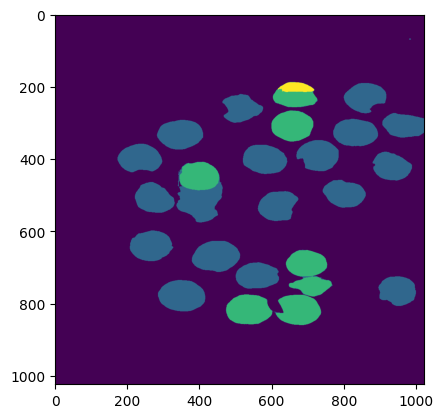

In [13]:
label_0 = np.where(clustering.labels_ == 0)
print("Number of items in cluster 0: ", label_0[0].shape)

lbl0_semantic_seg_mask = masks2[-1]['segmentation']*1
for seg_no in label_0[0]:
    lbl0_semantic_seg_mask += masks2[seg_no]['segmentation']*1

# Plottign the label 0 semantic mask
plt.imshow(lbl0_semantic_seg_mask)

## Final Output

In [14]:
binary_ind = np.where(lbl0_semantic_seg_mask > 0)
mask = lbl0_semantic_seg_mask.copy()
mask[binary_ind] = 1

img_mask = img_rgb.copy()
img_mask[:,:,0] = img_mask[:,:,0]*mask
img_mask[:,:,1] = img_mask[:,:,1]*mask
img_mask[:,:,2] = img_mask[:,:,2]*mask

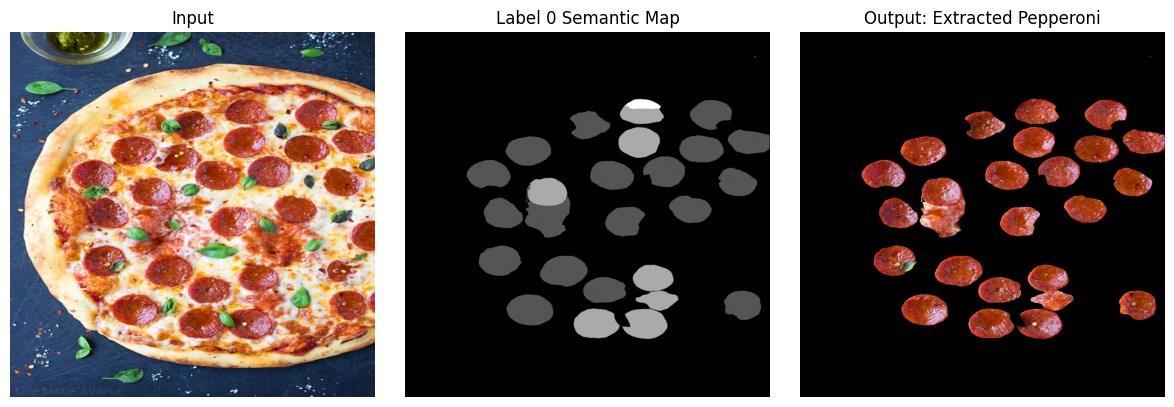

In [15]:
# Create a figure and three subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot the first image on the first subplot
axes[0].imshow(img_rgb, cmap='gray')
axes[0].set_title('Input')
axes[0].axis('off')  # Hide axes

# Plot the second image on the second subplot
axes[1].imshow(lbl0_semantic_seg_mask, cmap='gray')
axes[1].set_title('Label 0 Semantic Map')
axes[1].axis('off')  # Hide axes

# Plot the third image on the third subplot
axes[2].imshow(img_mask, cmap='gray')
axes[2].set_title('Output: Extracted Pepperoni')
axes[2].axis('off')  # Hide axes

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [16]:
import numpy as np

def sam_masks_to_dict(masks):
    """
    Convert SAM masks list into a dict keyed by mask_id strings.

    Args:
      masks: list of dicts from mask_generator.generate(img)
    Returns:
      dict: keys = "mask_000", values = metadata dict (area, bbox, etc.)
    """
    mask_dict = {}
    for i, ann in enumerate(masks):
        key = f"mask_{i:03d}"
        # core metadata
        rec = {
            "mask_id": i,
            "area": int(ann.get("area", 0)),
            "bbox": [int(x) for x in ann.get("bbox", [0,0,0,0])],
            "predicted_iou": float(ann.get("predicted_iou", -1)),
            "stability_score": float(ann.get("stability_score", -1)),
            # keep the segmentation as a numpy array in-memory
            "segmentation": ann["segmentation"].astype(np.uint8),
        }
        # optional provenance if present
        if "crop_box" in ann:
            rec["crop_box"] = [int(x) for x in ann["crop_box"]]
        if "point_coords" in ann:
            rec["point_coords"] = ann["point_coords"]
        if "point_labels" in ann:
            rec["point_labels"] = ann["point_labels"]

        mask_dict[key] = rec

    return mask_dict

masks = mask_generator.generate(img_rgb)
mask_data = sam_masks_to_dict(masks)

# Inspect keys
print(mask_data.keys())   # e.g., dict_keys(['mask_000','mask_001',...])

# Access one mask's info
m0 = mask_data["mask_000"]
print("Area:", m0["area"], "BBox:", m0["bbox"], "IoU:", m0["predicted_iou"])

# Get the segmentation mask (numpy array, shape HxW)
mask_img = m0["segmentation"]
print(mask_img.shape, mask_img.dtype)

print(mask_data)

dict_keys(['mask_000', 'mask_001', 'mask_002', 'mask_003', 'mask_004', 'mask_005', 'mask_006', 'mask_007', 'mask_008', 'mask_009', 'mask_010', 'mask_011', 'mask_012', 'mask_013', 'mask_014', 'mask_015', 'mask_016', 'mask_017', 'mask_018', 'mask_019', 'mask_020', 'mask_021', 'mask_022', 'mask_023', 'mask_024', 'mask_025', 'mask_026', 'mask_027', 'mask_028', 'mask_029', 'mask_030', 'mask_031', 'mask_032', 'mask_033', 'mask_034', 'mask_035', 'mask_036', 'mask_037', 'mask_038', 'mask_039', 'mask_040', 'mask_041', 'mask_042', 'mask_043', 'mask_044', 'mask_045', 'mask_046', 'mask_047', 'mask_048', 'mask_049', 'mask_050', 'mask_051', 'mask_052', 'mask_053', 'mask_054', 'mask_055', 'mask_056', 'mask_057', 'mask_058', 'mask_059', 'mask_060', 'mask_061', 'mask_062', 'mask_063', 'mask_064', 'mask_065', 'mask_066', 'mask_067', 'mask_068', 'mask_069', 'mask_070', 'mask_071', 'mask_072', 'mask_073', 'mask_074', 'mask_075', 'mask_076', 'mask_077', 'mask_078', 'mask_079', 'mask_080', 'mask_081', 'mask

How many images do you want to upload? 1

Upload image 1 of 1 …


Saving Basketball.png to Basketball.png

Collected 1 images: ['Basketball.png']


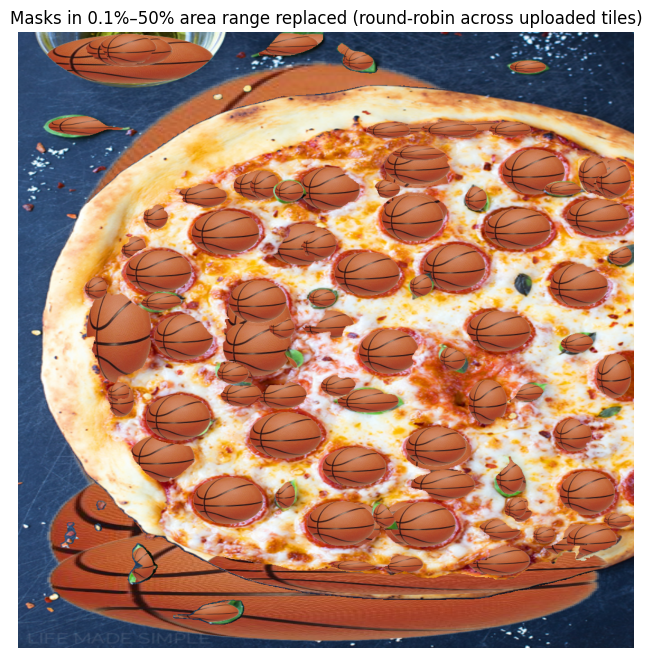

In [17]:
# --- Replace masks between 0.5% and 1.5% of total image area using N user-uploaded images ---

import cv2, numpy as np, matplotlib.pyplot as plt, urllib.request, os
from google.colab import files

# ---------- helpers ----------
def imread_rgba(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise FileNotFoundError(f"Could not read image at: {path}")
    if img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGRA)
    elif img.shape[2] == 3:
        h, w = img.shape[:2]
        a = np.full((h, w, 1), 255, np.uint8)
        img = np.concatenate([img, a], axis=2)
    # BGRA -> RGBA
    img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)
    return img

def auto_make_background_transparent(rgba, thresh=18, min_keep_ratio=0.20):
    """
    Remove background by keying approximate border color in LAB space + cleanup.
    Works well for product-style images with uniform-ish borders; preserves existing alpha.
    """
    rgb = rgba[:, :, :3]
    H, W = rgb.shape[:2]
    border = np.concatenate([rgb[0], rgb[-1], rgb[:,0], rgb[:,-1]], axis=0).astype(np.uint8)
    lab = cv2.cvtColor(rgb, cv2.COLOR_RGB2LAB)
    border_lab = cv2.cvtColor(border.reshape(-1,1,3), cv2.COLOR_RGB2LAB).reshape(-1,3)
    ref = np.median(border_lab, axis=0)
    d = lab.astype(np.float32)
    dist = np.sqrt(np.sum((d - ref.reshape(1,1,3))**2, axis=2))
    bg_mask = (dist < thresh).astype(np.uint8)*255

    # Keep background connected to edges
    flood = np.zeros((H+2, W+2), np.uint8)
    bg_ff = bg_mask.copy()
    for seed in [(0,0),(W-1,0),(0,H-1),(W-1,H-1)]:
        try: cv2.floodFill(bg_ff, flood, seed, 254)
        except: pass
    bg_connected = (bg_ff == 254).astype(np.uint8)*255

    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    bg_connected = cv2.morphologyEx(bg_connected, cv2.MORPH_OPEN, k, iterations=1)
    bg_connected = cv2.morphologyEx(bg_connected, cv2.MORPH_CLOSE, k, iterations=1)

    fg = (bg_connected == 0).astype(np.uint8)
    new_alpha = (fg * 255).astype(np.uint8)

    # Safety: if we removed too much, invert decision
    if new_alpha.sum() < min_keep_ratio * 255 * H * W:
        new_alpha = 255 - bg_connected

    out = rgba.copy()
    out[:, :, 3] = np.minimum(out[:, :, 3], new_alpha)  # respect existing alpha
    return out

def to_rgba(img_rgb):
    if img_rgb.shape[2] == 3:
        a = np.full(img_rgb.shape[:2] + (1,), 255, np.uint8)
        return np.concatenate([img_rgb, a], axis=2)
    return img_rgb

def alpha_composite(dst_rgba, src_rgba, x, y):
    H, W = dst_rgba.shape[:2]
    h, w = src_rgba.shape[:2]
    if w <= 0 or h <= 0: return
    x0, y0 = max(0, int(x)), max(0, int(y))
    x1, y1 = min(W, x0 + int(w)), min(H, y0 + int(h))
    if x1 <= x0 or y1 <= y0: return
    sx0, sy0 = x0 - int(x), y0 - int(y)
    sx1, sy1 = sx0 + (x1 - x0), sy0 + (y1 - y0)

    dst = dst_rgba[y0:y1, x0:x1].astype(np.float32)
    src = src_rgba[sy0:sy1, sx0:sx1].astype(np.float32)

    a = src[:, :, 3:4] / 255.0
    out_rgb = a * src[:, :, :3] + (1.0 - a) * dst[:, :, :3]
    out_a   = np.maximum(dst[:, :, 3:4], src[:, :, 3:4])
    dst_rgba[y0:y1, x0:x1, :3] = out_rgb.clip(0, 255).astype(np.uint8)
    dst_rgba[y0:y1, x0:x1, 3:4] = out_a.clip(0, 255).astype(np.uint8)

def replace_area_fraction_with_tiles(img_rgb, mask_data, tiles_rgba,
                                     keep_aspect=True, lower=0.005, upper=0.5):
    """
    Replace masks whose areas are within [lower, upper] fraction of total image area.
    Distribute multiple tiles round-robin over selected masks.
    """
    H, W = img_rgb.shape[:2]
    total_area = H * W
    low_px = lower * total_area
    high_px = upper * total_area

    canvas = to_rgba(img_rgb.copy())

    # Collect masks within absolute area range
    items = []
    for k, info in mask_data.items():
        area = int(info.get("area", 0))
        bbox = info.get("bbox", [0,0,0,0])
        if not isinstance(bbox, (list, tuple)) or len(bbox) != 4:
            continue
        x, y, w, h = bbox
        if area <= 0 or w <= 0 or h <= 0:
            continue
        if low_px <= area <= high_px:
            items.append((k, info, area))

    if not items or not tiles_rgba:
        return canvas[:, :, :3]

    # Paste larger ones first for nicer overlaps
    items.sort(key=lambda t: t[2], reverse=True)

    m = len(tiles_rgba)
    for idx, (key, info, area) in enumerate(items):
        tile_src = tiles_rgba[idx % m]

        x, y, w, h = [int(v) for v in info["bbox"]]
        x = max(0, x); y = max(0, y)
        w = max(1, min(w, W - x)); h = max(1, min(h, H - y))
        if w <= 0 or h <= 0: continue

        if keep_aspect:
            fh, fw = tile_src.shape[:2]
            scale = min(w / fw, h / fh)
            tw, th = max(1, int(round(fw * scale))), max(1, int(round(fh * scale)))
            resized = cv2.resize(tile_src, (tw, th), interpolation=cv2.INTER_AREA)
            # letterbox into bbox
            tile = np.zeros((h, w, 4), np.uint8)
            ox, oy = (w - tw) // 2, (h - th) // 2
            tile[oy:oy+th, ox:ox+tw] = resized
        else:
            tile = cv2.resize(tile_src, (w, h), interpolation=cv2.INTER_AREA)

        seg = info["segmentation"].astype(np.uint8)
        if seg.max() == 1: seg *= 255
        matte = seg[y:y+h, x:x+w]
        if matte.size == 0: continue

        a_tile = tile[:, :, 3]
        combined_alpha = (a_tile.astype(np.float32)/255.0) * (matte.astype(np.float32)/255.0)
        tile_rgba = tile.copy()
        tile_rgba[:, :, 3] = np.clip(combined_alpha * 255.0, 0, 255).astype(np.uint8)

        alpha_composite(canvas, tile_rgba, x, y)

    return canvas[:, :, :3]

# ---------- prompt for N images and upload one-by-one ----------
while True:
    try:
        n_imgs = int(input("How many images do you want to upload? "))
        if n_imgs <= 0:
            print("Please enter a positive integer.")
            continue
        break
    except Exception:
        print("Please enter a valid integer.")

tiles_rgba = []
picked = []

for i in range(n_imgs):
    print(f"\nUpload image {i+1} of {n_imgs} …")
    up = files.upload()   # user picks one file here
    if not up:
        print("No file selected; skipping this slot.")
        continue
    fname = list(up.keys())[0]  # if multiple selected, take the first
    picked.append(fname)
    rgba = imread_rgba(fname)
    rgba = auto_make_background_transparent(rgba, thresh=18, min_keep_ratio=0.15)
    tiles_rgba.append(rgba)

print(f"\nCollected {len(tiles_rgba)} images:", picked if picked else "(none)")

# Fallback if none uploaded
if not tiles_rgba:
    print("No uploads detected; using two sample tiles as fallback.")
    urls = [
        "https://upload.wikimedia.org/wikipedia/commons/0/09/Soccer_ball.svg.png",
        "https://upload.wikimedia.org/wikipedia/commons/8/80/Basketball.png"
    ]
    for i, url in enumerate(urls):
        p = f"tile_fallback_{i}.png"
        urllib.request.urlretrieve(url, p)
        rgba = imread_rgba(p)
        rgba = auto_make_background_transparent(rgba, thresh=18, min_keep_ratio=0.15)
        tiles_rgba.append(rgba)

# ---------- run replacement on the 0.5%–1.5% area range ----------
out_rgb = replace_area_fraction_with_tiles(
    img_rgb=img_rgb,          # must already exist from your SAM step
    mask_data=mask_data,      # must already exist from your SAM step
    tiles_rgba=tiles_rgba,
    keep_aspect=False,
    lower=0.001,              # 0.5% of total image area
    upper=0.5               # 1.5% of total image area
)

plt.figure(figsize=(8,8))
plt.imshow(out_rgb)
plt.axis("off")
plt.title("Masks in 0.1%–50% area range replaced (round-robin across uploaded tiles)")
plt.show()


In [19]:
import argparse

import cv2
import numpy as np


def get_center_of_mass(mask: np.ndarray) -> tuple[int, int]:
    """Calculate the center of mass of a binary mask."""
    y_indices, x_indices = np.nonzero(mask)
    if len(x_indices) == 0 or len(y_indices) == 0:
        return (mask.shape[1] // 2, mask.shape[0] // 2)  # Default to center if no mass
    center_x = int(np.mean(x_indices))
    center_y = int(np.mean(y_indices))
    return (center_x, center_y)


def raycast(mask: np.ndarray, center: np.ndarray, direction: np.ndarray) -> np.ndarray:
    """Perform raycasting from the center in the given direction until hitting the mask boundary."""
    height, width = mask.shape
    x, y = center
    dx, dy = direction / np.linalg.norm(direction)

    while 0 <= int(x) < width and 0 <= int(y) < height:
        if mask[int(y), int(x)] == 0:  # Assuming mask is binary with 0 as background
            break
        x += dx
        y += dy

    return np.array([x, y])


def reverse_raycast(
    mask: np.ndarray, center: np.ndarray, direction: np.ndarray
) -> np.ndarray:
    """Raycast from outside towards the center until hitting the mask boundary."""
    height, width = mask.shape
    x, y = center
    dx, dy = direction / np.linalg.norm(direction)

    # Start from a point far outside the image in the `direction`
    x += dx * max(width, height)
    y += dy * max(width, height)

    while (
        not (0 <= int(x) < width and 0 <= int(y) < height) or mask[int(y), int(x)] == 0
    ):
        x -= dx
        y -= dy

    return np.array([x, y])


class PolarMapping:
    def __init__(self, image: np.ndarray):
        self.image = image
        self.center_of_mass = get_center_of_mass(image[:, :, 3])
        self.n_rays = 100
        self.boundary_points = self.convert_to_polar(self.center_of_mass, self.n_rays)

    def convert_to_polar(self, center: tuple[int, int], n_rays: int) -> np.ndarray:
        boundary_points = []
        for i in range(n_rays):
            radians = np.deg2rad(i * (360 / n_rays))
            direction = np.array([np.cos(radians), np.sin(radians)])
            boundary_point = reverse_raycast(
                self.image[:, :, 3], np.array(center), direction
            )
            boundary_points.append(boundary_point)

        return np.array(boundary_points)

    def pixel_at_polar(self, radians: float, radius_fraction: float) -> np.ndarray:
        """Get color at a specific polar coordinate.

        Interpolate between the boundary points to find the pixel color.
        """
        # Find the two boundary points to interpolate between
        angle_index_float = (radians / (2 * np.pi)) * (self.n_rays)
        angle_index = int(np.floor(angle_index_float))
        interpolation_factor = angle_index_float - angle_index
        assert -1e-9 < interpolation_factor < 1 + 1e-9, f"{interpolation_factor=}"

        p1 = self.boundary_points[angle_index % self.n_rays]
        p2 = self.boundary_points[(angle_index + 1) % self.n_rays]

        # Interpolate between p1 and p2
        interpolated_point = p1 + (p2 - p1) * (interpolation_factor)

        interpolated_point = (
            self.center_of_mass
            + (interpolated_point - self.center_of_mass) * radius_fraction
        )

        return interpolated_point

    def get_boundary_point(self, radians: float) -> np.ndarray:
        """Get the boundary point at a specific angle."""
        return self.pixel_at_polar(radians, 1.0)

    def polar_at_pixel(self, p: np.ndarray) -> tuple[float, float]:
        """Convert pixel coordinates to polar coordinates."""
        delta = p - self.center_of_mass
        angle = np.arctan2(delta[1], delta[0])
        boundary = self.get_boundary_point(angle)

        radius = np.linalg.norm(delta) / np.linalg.norm(boundary - self.center_of_mass)
        return (angle, radius)

    def contour(self) -> np.ndarray:
        """Return a grayscale image showing the contour."""
        contour_image = np.zeros(self.image.shape[:2], dtype=np.uint8)
        # Draw polygon using opencv
        pts = self.boundary_points.reshape((-1, 1, 2)).astype(np.int32)
        cv2.polylines(contour_image, [pts], isClosed=True, color=255, thickness=1)
        return contour_image


def dion_stretch(source: np.ndarray, target: np.ndarray) -> np.ndarray:
    """Apply Dion's stretch algorithm to warp the source image to match the target image."""
    source_mapping = PolarMapping(source)

    # For debugging: visualize source contour
    # return source_mapping.contour()

    target_mapping = PolarMapping(target)

    height, width = target.shape[:2]
    output = np.zeros_like(target)

    for y in range(height):
        for x in range(width):
            angle, radius = target_mapping.polar_at_pixel(np.array([x, y]))

            if radius > 1.0:
                output[y, x] = 0
                continue

            # For debugging: visualize polar coordinates
            # output[y, x, 0] = radius * 255
            # output[y, x, 1] = angle / (np.pi * 2) * 255
            # output[y, x, 3] = 255

            source_point = source_mapping.pixel_at_polar(angle, radius)

            sx, sy = int(source_point[0]), int(source_point[1])
            if 0 <= sx < source.shape[1] and 0 <= sy < source.shape[0]:
                output[y, x] = source[sy, sx]

    # Apply alpha mask of target to output
    output[:, :, 3] = target[:, :, 3]

    return output

# === Colab interface ===
print("Upload your SOURCE image (RGBA, .png recommended)")
uploaded = files.upload()
source_path = list(uploaded.keys())[0]

print("Upload your TARGET image (RGBA, .png recommended)")
uploaded = files.upload()
target_path = list(uploaded.keys())[0]

# load images
source_img = cv2.imread(source_path, cv2.IMREAD_UNCHANGED)
target_img = cv2.imread(target_path, cv2.IMREAD_UNCHANGED)

assert source_img.shape[2] == 4, "Source image must have an alpha channel"
assert target_img.shape[2] == 4, "Target image must have an alpha channel"

# run stretch
output_img = dion_stretch(source_img, target_img)

# save + download result
out_path = "output.png"
cv2.imwrite(out_path, output_img)
files.download(out_path)
print("Done! Downloaded as output.png")

Upload your SOURCE image (RGBA, .png recommended)


Saving Basketball.png to Basketball (1).png
Upload your TARGET image (RGBA, .png recommended)


Saving car.webp to car.webp


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Done! Downloaded as output.png


How many replacement images do you want to upload? 2

Upload replacement image 1 of 2 …


Saving Basketball.png to Basketball (2).png

Upload replacement image 2 of 2 …


Saving images.jpeg to images (1).jpeg
Collected 2 replacement images: ['Basketball (2).png', 'images (1).jpeg']


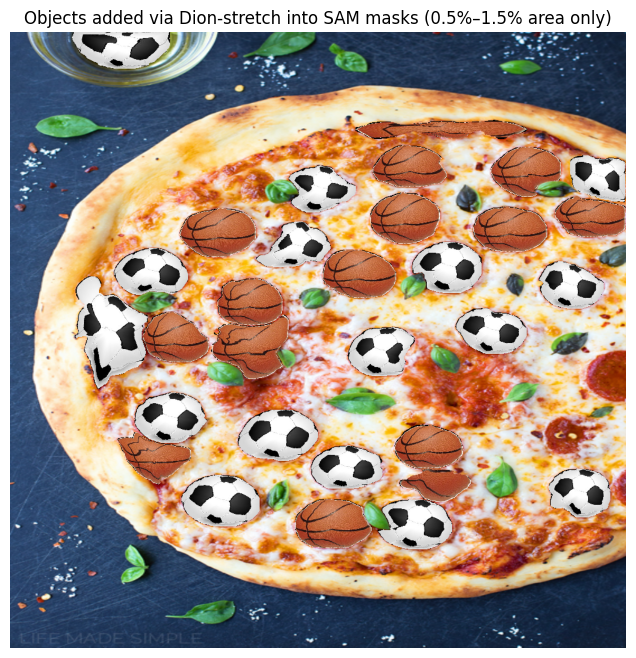

In [21]:
# === Add/Run this cell AFTER your last one ===
# Uses: img_rgb, mask_data, dion_stretch(), alpha_composite()

import cv2, numpy as np, math
from google.colab import files
import matplotlib.pyplot as plt

# ---------- small helpers ----------
def ensure_rgba(img):
    if img is None: return None
    if img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGRA)
    elif img.shape[2] == 3:
        h, w = img.shape[:2]
        a = np.full((h, w, 1), 255, np.uint8)
        img = np.concatenate([img, a], axis=2)
    return cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)

def auto_make_background_transparent(rgba, thresh=18, min_keep_ratio=0.20):
    rgb = rgba[:, :, :3]
    H, W = rgb.shape[:2]
    border = np.concatenate([rgb[0], rgb[-1], rgb[:,0], rgb[:,-1]], axis=0).astype(np.uint8)
    lab = cv2.cvtColor(rgb, cv2.COLOR_RGB2LAB)
    border_lab = cv2.cvtColor(border.reshape(-1,1,3), cv2.COLOR_RGB2LAB).reshape(-1,3)
    ref = np.median(border_lab, axis=0)
    dist = np.sqrt(np.sum((lab.astype(np.float32) - ref.reshape(1,1,3))**2, axis=2))
    bg_mask = (dist < thresh).astype(np.uint8)*255
    flood = np.zeros((H+2, W+2), np.uint8)
    bg_ff = bg_mask.copy()
    for seed in [(0,0),(W-1,0),(0,H-1),(W-1,H-1)]:
        try: cv2.floodFill(bg_ff, flood, seed, 254)
        except: pass
    bg_connected = (bg_ff == 254).astype(np.uint8)*255
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    bg_connected = cv2.morphologyEx(bg_connected, cv2.MORPH_OPEN, k, iterations=1)
    bg_connected = cv2.morphologyEx(bg_connected, cv2.MORPH_CLOSE, k, iterations=1)
    fg = (bg_connected == 0).astype(np.uint8)
    new_alpha = (fg * 255).astype(np.uint8)
    if new_alpha.sum() < min_keep_ratio * 255 * H * W:
        new_alpha = 255 - bg_connected
    out = rgba.copy()
    out[:, :, 3] = np.minimum(out[:, :, 3], new_alpha)
    return out

def trim_to_alpha(rgba):
    a = rgba[:, :, 3]
    ys, xs = np.where(a > 0)
    if ys.size == 0 or xs.size == 0: return rgba
    y0, y1 = ys.min(), ys.max() + 1
    x0, x1 = xs.min(), xs.max() + 1
    return rgba[y0:y1, x0:x1]

def to_rgba(img_rgb):
    if img_rgb.shape[2] == 3:
        a = np.full(img_rgb.shape[:2] + (1,), 255, np.uint8)
        return np.concatenate([img_rgb, a], axis=2)
    return img_rgb

# ---------- user uploads ----------
while True:
    try:
        n_imgs = int(input("How many replacement images do you want to upload? "))
        if n_imgs <= 0:
            print("Please enter a positive integer.")
            continue
        break
    except:
        print("Please enter a valid integer.")

tiles, names = [], []
for i in range(n_imgs):
    print(f"\nUpload replacement image {i+1} of {n_imgs} …")
    up = files.upload()
    if not up:
        print("No file chosen, skipping this slot.")
        continue
    fname = list(up.keys())[0]
    raw = cv2.imread(fname, cv2.IMREAD_UNCHANGED)
    rgba = ensure_rgba(raw)
    rgba = auto_make_background_transparent(rgba, thresh=18, min_keep_ratio=0.15)
    rgba = trim_to_alpha(rgba)
    tiles.append(rgba); names.append(fname)

if not tiles:
    raise RuntimeError("No replacement images uploaded.")

print(f"Collected {len(tiles)} replacement images:", names)

# ---------- STRICT area filter: only masks in [0.5%, 1.5%] of image area ----------
LOW_FRAC = 0.005   # 0.5%
HIGH_FRAC = 0.015  # 1.5%

H, W = img_rgb.shape[:2]
total_area = H * W
low_px  = LOW_FRAC  * total_area
high_px = HIGH_FRAC * total_area

items = []
for k, info in mask_data.items():
    area = int(info.get("area", 0))
    x, y, w, h = info.get("bbox", [0,0,0,0])
    if area <= 0 or w <= 0 or h <= 0:
        continue
    if low_px <= area <= high_px:
        items.append((k, info, area))

if not items:
    raise RuntimeError("No masks in the 0.5%–1.5% area range. Try loosening the bounds.")

# sort largest-first for nicer overlaps
items.sort(key=lambda t: t[2], reverse=True)

# ---------- apply Dion-stretch per eligible mask ----------
canvas = to_rgba(img_rgb.copy())
m = len(tiles)

for idx, (key, info, area) in enumerate(items):
    x, y, w, h = [int(v) for v in info["bbox"]]
    x = max(0, x); y = max(0, y)
    w = max(1, min(w, W - x)); h = max(1, min(h, H - y))
    if w <= 0 or h <= 0:
        continue

    # build target silhouette from SAM mask crop
    seg = info["segmentation"].astype(np.uint8)
    if seg.max() == 1: seg *= 255
    matte = seg[y:y+h, x:x+w]
    if matte.size == 0:
        continue

    target_rgba = np.zeros((h, w, 4), np.uint8)
    target_rgba[:, :, 3] = matte  # shape comes from the mask

    # pick a tile round-robin, trimmed to alpha
    src_rgba = trim_to_alpha(tiles[idx % m])

    # warp source into target silhouette (Dion-stretch)
    warped = dion_stretch(src_rgba, target_rgba)

    # paste back at (x,y)
    alpha_composite(canvas, warped, x, y)

# ---------- show result ----------
out_rgb = canvas[:, :, :3]
plt.figure(figsize=(8,8))
plt.imshow(out_rgb)
plt.axis("off")
plt.title("Objects added via Dion-stretch into SAM masks (0.5%–1.5% area only)")
plt.show()
